# <font color=green|black>**Kevyn Andrade Marcelino - Análise Grupo Mateus** </font>

## Raciocínio lógico inicial:

#### 1. Extração de dados (Começar com selenium e ver se tem algum melhor):

##### 1.1 Extrair do próprio Grupo Mateus
    - Fazer webscrapping da página: https://ofertasmateus.com
    - Armazenar cada loja e automatizar para procurar no google
    - Pegar automaticamente o nome da loja e botar num df
    - Possivelmente já pegar latitude e longitude, separar coluna de cidade, estado, bairro (granularidade)
    - E os concorrentes e tentar plotar tb, vish

##### 1.2 Extrair dos Concorrentes

#### 2. Pegar dados demográficos do IBGE, principalmente renda e população

#### 3. Plotar no mapa essas Todas as lojas do grupo e de concorrentes

##### 3.1 Análise canibalização das lojas, estratégia, etc
##### 3.2 Análise Em conjunto dos dados demográficos, tanto no mapa, como em forma tabular
##### 3.3 Análise mais voltada aos concorrentes

#### 4. Hipóteses, conclusões, etc

# Imports Gerais

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

# Importando lib para ver o progresso do código
from tqdm.notebook import tqdm_notebook


# 1. Extração de Dados

## 1.1 - Lojas do Grupo

- A primeira dificuldade foi encontrar um lugar em que pudesse encontrar todas as lojas do grupo, por sorte encontrei esse site: https://ofertasmateus.com, que por meio de webscrapping foi possível percorrer cada estado, cidade, e salvar o nome de cada loja em uma planilha chamada 'lojas.xlsx' (arrumar o código, pois está muito ineficiente e depois colocar aqui
- Provavelmente há algum jeito mais fácil de pegar os dados, mas entrei em contato por chat com a empresa e me falaram que tinham essa informação no site e me passaram um telefone do nordeste que ficou inviável me comunicar
- Também mandei email para o relacionamento com investidores, mas não obtive qualquer resposta
- Também havia a possibilidade de se obter usando a raíz do cnpj, mas não estava sendo muito produtivo

- Faltam lojas como eletro mateus e outras da rede
    - Eletro dá para obter em: https://www.mateusonline.com.br > 'Nossas Lojas'

In [3]:
# Lendo a planilha e visualizando sua estrutura:
# Apesar de parecer a princípio que o nome da loja e da cidade são iguais, não é bem o caso, há situações..
# ..principalmente quando há muitas lojas em uma mesma cidade no qual isso não é válido
lojas = pd.read_excel('lojas.xlsx')
lojas


,Tipo de Loja,Loja,Estado,Cidade
0,Mix Mateus,Juazeiro,Ba,Juazeiro
1,Mix Mateus,Teixeira de freitas,Ba,Teixeira de freitas
2,Mix Mateus,Floriano,PI,Floriano
3,Mix Mateus,Parnaíba,PI,Parnaíba
4,Mateus Supermercados,Piripiri,PI,Piripiri
...,...,...,...,...
123,Camiño Supermercados,Vitorino Freire,Ma,Vitorino Freire
124,Camiño Supermercados,Zé Doca,Ma,Zé Doca
125,Mix Mateus,Itapipoca,Ce,Itapipoca
126,Mix Mateus,Sobral,Ce,Sobral


## 1.2 Extração dos Endereços de cada loja

- Após obter acima o nome de cada loja, a lógica foi procurar no google o nome de cada uma e pegar o endereço que aparece na primeira página
- O problema é que nem todas mostram essa informação de forma fácil

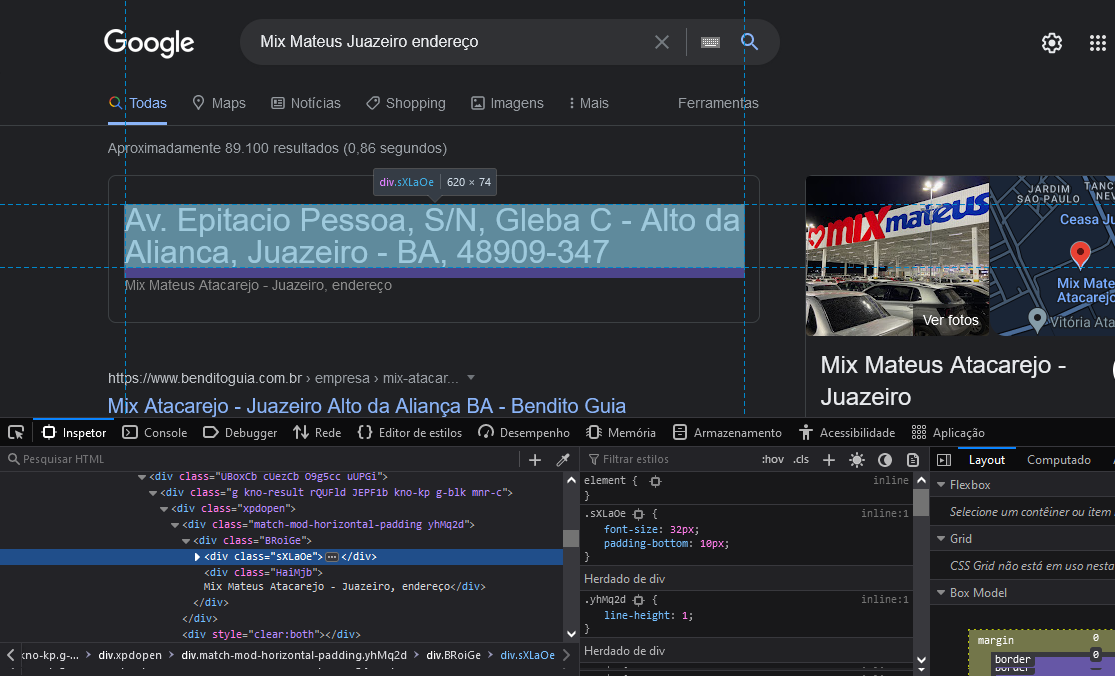

### 1.2.1 Usando Selenium

In [5]:
# Imports
from selenium.webdriver import Firefox, Chrome
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

from time import sleep


In [9]:
# Opening browser
f = Firefox() # Opens firefox

# opens the url defined
url = 'https://www.google.com/'
f.get(url) 

# Waiting webpage to load
sleep(3)


In [10]:
# Teste com uma das lojas para ver se funciona
key = "Mix Mateus Floriano"
f.get("https://www.google.co.in/search?q=" + key + ' endereço' )


In [11]:
# Tudo Ok
xpath = '/html/body/div[7]/div/div[10]/div[1]/div[2]/div[2]/div/div/div[1]/div/div/div/div/div[1]/div/div[1]'
end = f.find_element_by_xpath(xpath).text
print(end)


BR-230, S/N - Sambaíba, Floriano - PI, 64804-140


### Obs. A função está bem ineficiente pois usei sleep, precisaria usar método para o selenium 'ler' quando a página já carregou e não usar, mas não dá tempo de procurar agora

In [12]:
# Função simples para obter todos os endereços a partir do df de lojas

# Criando lista para armazenar os endereços
lista = []
# Variável com quantidade de erros
errors = 0

# Testando leitura das lojas
for linha in tqdm_notebook(lojas.index):
    # Armazenando o nome completo da loja
    key = (lojas['Tipo de Loja'][linha] + ' ' + lojas['Loja'][linha] + ' endereço')
    print(f'Armazenando endereço da loja: {key}') # Só para teste, comentar essa linha ao acabar
    
    # Substituindo na URL de pesquisa do google para procurar cada loja
    f.get("https://www.google.co.in/search?q="+key)
    # Tempo para a página carregar - Não é o mais eficiente, porém depois eu melhoro
    sleep(2)
    # Onde está localizado na página:
    xpath = '/html/body/div[7]/div/div[10]/div[1]/div[2]/div[2]/div/div/div[1]/div/div/div/div/div[1]/div/div[1]'
    
    # Algumas vezes a estrutura da página muda e o endereço não aparece, por isso necessário try and except
    try:
        # O endereço da loja fica armazenado nesse xpath em questão - peguei usando o inspecionar
        address = f.find_element_by_xpath(xpath).text
    # Se der erro colocar qual o nome da loja para procurar manualmente
    except:
        address = f'{key} não encontrado'
        errors += 1
        
    # Adicionando ao final da lista cada endereço
    lista.append(address)
    

Armazenando endereço da loja: Mix Mateus Juazeiro endereço
Armazenando endereço da loja: Mix Mateus Teixeira de freitas endereço
Armazenando endereço da loja: Mix Mateus Floriano endereço
Armazenando endereço da loja: Mix Mateus Parnaíba endereço
Armazenando endereço da loja: Mateus Supermercados Piripiri endereço
Armazenando endereço da loja: Mix Mateus Terezina Zona Sul endereço
Armazenando endereço da loja: Mix Mateus Terezina Zequinha Freire endereço
Armazenando endereço da loja: Mix Mateus Aracaju endereço
Armazenando endereço da loja: Mix Mateus Petrolina endereço
Armazenando endereço da loja: Mix Mateus Abaetetuba endereço
Armazenando endereço da loja: Mix Mateus Altamira endereço
Armazenando endereço da loja: Mix Mateus Coqueiro 40h endereço
Armazenando endereço da loja: Mix Mateus Mário Covas endereço
Armazenando endereço da loja: Mateus Supermercados Jaderlândia endereço
Armazenando endereço da loja: Mateus Supermercados Maguari endereço
Armazenando endereço da loja: Mateus S

Armazenando endereço da loja: Camiño Supermercados Viana endereço
Armazenando endereço da loja: Camiño Supermercados Vitorino Freire endereço
Armazenando endereço da loja: Camiño Supermercados Zé Doca endereço
Armazenando endereço da loja: Mix Mateus Itapipoca endereço
Armazenando endereço da loja: Mix Mateus Sobral endereço
Armazenando endereço da loja: Mix Mateus Tianguá endereço



In [31]:
# Quase 14 minutos rodando o código - bs4 foi bem melhor, mas sem o sleep tb teria sido viável
# Conferindo se quantidade de linhas bate com a quantidade de lojas:
print(f'Quantidade de linhas: {len(lista)}')

# Conferindo se quantidade de linhas em que não foram encontrados o endereço:
print(f'Quantidade de linhas com falha: {errors}')

# Vendo a lista:
lista


Quantidade de linhas: 128
Quantidade de linhas com falha: 38


['Av. Epitacio Pessoa, S/N, Gleba C - Alto da Alianca, Juazeiro - BA, 48909-347',
 'Av. Pres. Getúlio Vargas, 7979 - Sector Bahia Sul, Teixeira de Freitas - BA, 45995-002',
 'BR-230, S/N - Sambaíba, Floriano - PI, 64804-140',
 'R. Projetada, 67 - Reis Veloso, Parnaíba - PI',
 'Av. Dep. Raimundo Holanda, 1319 - Morro da Saudade, Piripiri - PI, 64260-000',
 'Av. Henry Wall de Carvalho, 5300A - Parque São João, Teresina - PI, 64020-720',
 'Av. Zequinha Freire, 1350 - Uruguai, Teresina - PI, 64073-020',
 'Av. Chanceler Osvaldo Aranha, 1110 - José Conrado de Araújo, Aracaju - SE, 49085-100',
 'Av. Dr. Ulisses Guimarães, 423 - Jardim Amazonas, Petrolina - PE, 56313-295',
 'PA-409, 340 - Abaetetuba, PA, 68440-000',
 'Mix Mateus Altamira endereço não encontrado',
 'Prox. a rotatória do - Av. Gov. Hélio Gueiros, 0 - Coqueiro, Ananindeua - PA, 67120-527',
 'Rod. Mário Covas, 1228 - Coqueiro, Ananindeua - PA, 67113-330',
 'R. São Benedito, 506 - Atalaia, Ananindeua - PA, 67013-838',
 'Av. Cláudio

### 1.2.2 Usando BeautifulSoup

- Nunca tinha usado, mas me falaram que era bem mais rápido por não precisar abrir outra guia
- Aprovado!

In [16]:
# Imports
import requests
from bs4 import BeautifulSoup


In [17]:
# Teste com uma loja 'Obtendo' a página
page = requests.get(f"https://www.google.co.in/search?q=Mix Mateus Juazeiro endereço")
soup = BeautifulSoup(page.content, 'html.parser')


In [27]:
# Com certeza tem algum jeito que já pega direto o endereço, mas ainda não consegui
end = str(soup.find_all(class_="BNeawe iBp4i AP7Wnd")[1])
end


'<div class="BNeawe iBp4i AP7Wnd">Av. Epitacio Pessoa, S/N, Gleba C - Alto da Alianca, Juazeiro - BA, 48909-347</div>'

In [28]:
# Necessário tratar um pouco o dado
end = end.split('>')[1]
end = end.split('<')[0]
end

'Av. Epitacio Pessoa, S/N, Gleba C - Alto da Alianca, Juazeiro - BA, 48909-347'

In [57]:
# Função simples para obter todos os endereços a partir do df de lojas

# Criando lista vazia
lista_bs4 = []
# Variável com quantidade de erros
errors = 0

# Testando leitura das lojas
for linha in tqdm_notebook(lojas.index):
    # Armazenando o nome completo da loja
    key = (lojas['Tipo de Loja'][linha] + ' ' + lojas['Loja'][linha] + ' endereço')
    print(f'Armazenando endereço da loja: {key}') # Só para teste, comentar essa linha ao acabar
    
    # Substituindo na URL de pesquisa do google para procurar cada loja
    page = requests.get(f"https://www.google.co.in/search?q={key}")
    soup = BeautifulSoup(page.content, 'html.parser')
    
    try:
        # Pegando o elemento que contém o endereço, transformando em str, depois fazendo um tratamento pra sobrar
        # .. apenas o endereço de fato
        address = str(soup.find_all(class_="BNeawe iBp4i AP7Wnd")[1]).split('>')[1]
        address = address.split('<')[0]
    except:
        address = f'{key} não encontrado'
        errors += 1
    
    # Adicionando ao final da lista cada endereço
    lista_bs4.append(address)


Armazenando endereço da loja: Mix Mateus Juazeiro endereço
Armazenando endereço da loja: Mix Mateus Teixeira de freitas endereço
Armazenando endereço da loja: Mix Mateus Floriano endereço
Armazenando endereço da loja: Mix Mateus Parnaíba endereço
Armazenando endereço da loja: Mateus Supermercados Piripiri endereço
Armazenando endereço da loja: Mix Mateus Terezina Zona Sul endereço
Armazenando endereço da loja: Mix Mateus Terezina Zequinha Freire endereço
Armazenando endereço da loja: Mix Mateus Aracaju endereço
Armazenando endereço da loja: Mix Mateus Petrolina endereço
Armazenando endereço da loja: Mix Mateus Abaetetuba endereço
Armazenando endereço da loja: Mix Mateus Altamira endereço
Armazenando endereço da loja: Mix Mateus Coqueiro 40h endereço
Armazenando endereço da loja: Mix Mateus Mário Covas endereço
Armazenando endereço da loja: Mateus Supermercados Jaderlândia endereço
Armazenando endereço da loja: Mateus Supermercados Maguari endereço
Armazenando endereço da loja: Mateus S

Armazenando endereço da loja: Camiño Supermercados Viana endereço
Armazenando endereço da loja: Camiño Supermercados Vitorino Freire endereço
Armazenando endereço da loja: Camiño Supermercados Zé Doca endereço
Armazenando endereço da loja: Mix Mateus Itapipoca endereço
Armazenando endereço da loja: Mix Mateus Sobral endereço
Armazenando endereço da loja: Mix Mateus Tianguá endereço



In [58]:
# 2 min rodando, pouca diferença, não? 🤯
# Conferindo se quantidade de linhas bate com a quantidade de lojas:
print(f'Quantidade de linhas: {len(lista_bs4)}')

# Conferindo se quantidade de linhas em que não foram encontrados o endereço:
# Tanto no Selenium quanto aqui ficaram faltando muitas lojas, tentar refinar isso depois
print(f'Quantidade de linhas com falha: {errors}')

# Vendo a lista:
lista_bs4


Quantidade de linhas: 128
Quantidade de linhas com falha: 22


['Av. Epitacio Pessoa, S/N, Gleba C - Alto da Alianca, Juazeiro - BA, 48909-347',
 'Av. Pres. Getúlio Vargas, 7979 - Sector Bahia Sul, Teixeira de Freitas - BA, 45995-002',
 'BR-230, S/N - Sambaíba, Floriano - PI, 64804-140',
 'R. Projetada, 67 - Reis Veloso, Parnaíba - PI',
 'Av. Dep. Raimundo Holanda, 1319 - Morro da Saudade, Piripiri - PI, 64260-000',
 'Av. Henry Wall de Carvalho, 5300A - Parque São João, Teresina - PI, 64020-720',
 'Av. Zequinha Freire, 1350 - Uruguai, Teresina - PI, 64073-020',
 'Av. Chanceler Osvaldo Aranha, 1110 - José Conrado de Araújo, Aracaju - SE, 49085-100',
 'Av. Dr. Ulisses Guimarães, 423 - Jardim Amazonas, Petrolina - PE, 56313-295',
 'PA-409, 340 - Abaetetuba, PA, 68440-000',
 'Mix Mateus Altamira endereço não encontrado',
 'Prox. a rotatória do - Av. Gov. Hélio Gueiros, 0 - Coqueiro, Ananindeua - PA, 67120-527',
 'Rod. Mário Covas, 1228 - Coqueiro, Ananindeua - PA, 67113-330',
 'R. São Benedito, 506 - Atalaia, Ananindeua - PA, 67013-838',
 'Av. Cláudio

In [59]:
# Transformando a lista em um DataFrame
# Transformando a lista de endereços em um DataFrame
address = pd.DataFrame(lista_bs4, columns = ['Endereço'])
address


,Endereço
0,"Av. Epitacio Pessoa, S/N, Gleba C - Alto da Al..."
1,"Av. Pres. Getúlio Vargas, 7979 - Sector Bahia ..."
2,"BR-230, S/N - Sambaíba, Floriano - PI, 64804-140"
3,"R. Projetada, 67 - Reis Veloso, Parnaíba - PI"
4,"Av. Dep. Raimundo Holanda, 1319 - Morro da Sau..."
...,...
123,"R. Pres. Castelo Branco, 208 - Centro, Vitorin..."
124,"Zé Doca - MA, 65365-000"
125,"R. Vicente Siebra, 3279 - B - Das Flores, Itap..."
126,"Rua Santos Medeiros, 200 - Jocely Dantas de An..."


In [55]:
# Salvando a planilha para colocar manualmente os faltantes
#address.to_excel('address.xlsx', index=False)

### 1.2.3 Abrindo Arquivo com todos os endereços - Falta fazer, continuar a análise por enquanto usando o DataFrame sem as lojas que deram problema

In [73]:
address_full = pd.read_excel('adress_full.xlsx')
address_full

# 2. Unindo e tratando alguns dados

## 2.1 Unindo 'lojas' com 'address' - não precisava ser nessa ordem

In [159]:
# Ok
lojas_full = pd.concat([lojas, address], axis=1, join='outer')
lojas_full


,Tipo de Loja,Loja,Estado,Cidade,Endereço
0,Mix Mateus,Juazeiro,Ba,Juazeiro,"Av. Epitacio Pessoa, S/N, Gleba C - Alto da Al..."
1,Mix Mateus,Teixeira de freitas,Ba,Teixeira de freitas,"Av. Pres. Getúlio Vargas, 7979 - Sector Bahia ..."
2,Mix Mateus,Floriano,PI,Floriano,"BR-230, S/N - Sambaíba, Floriano - PI, 64804-140"
3,Mix Mateus,Parnaíba,PI,Parnaíba,"R. Projetada, 67 - Reis Veloso, Parnaíba - PI"
4,Mateus Supermercados,Piripiri,PI,Piripiri,"Av. Dep. Raimundo Holanda, 1319 - Morro da Sau..."
...,...,...,...,...,...
123,Camiño Supermercados,Vitorino Freire,Ma,Vitorino Freire,"R. Pres. Castelo Branco, 208 - Centro, Vitorin..."
124,Camiño Supermercados,Zé Doca,Ma,Zé Doca,"Zé Doca - MA, 65365-000"
125,Mix Mateus,Itapipoca,Ce,Itapipoca,"R. Vicente Siebra, 3279 - B - Das Flores, Itap..."
126,Mix Mateus,Sobral,Ce,Sobral,"Rua Santos Medeiros, 200 - Jocely Dantas de An..."


## 2.2 Dividindo a coluna de endereço para granularizar os dados, isso vai ajudar mais a frente (Problema aqui é que os dados não vem de uma forma padronizada, mesmo com regex seria complicado, pois não então separado exatame só com virgula ou traço)

In [160]:
#Começar pelo Cep
lojas_full[['Endereço', 'Cep']] = lojas_full['Endereço'].str.rsplit(',', expand=True, n=1)
lojas_full

,Tipo de Loja,Loja,Estado,Cidade,Endereço,Cep
0,Mix Mateus,Juazeiro,Ba,Juazeiro,"Av. Epitacio Pessoa, S/N, Gleba C - Alto da Al...",48909-347
1,Mix Mateus,Teixeira de freitas,Ba,Teixeira de freitas,"Av. Pres. Getúlio Vargas, 7979 - Sector Bahia ...",45995-002
2,Mix Mateus,Floriano,PI,Floriano,"BR-230, S/N - Sambaíba, Floriano - PI",64804-140
3,Mix Mateus,Parnaíba,PI,Parnaíba,"R. Projetada, 67 - Reis Veloso",Parnaíba - PI
4,Mateus Supermercados,Piripiri,PI,Piripiri,"Av. Dep. Raimundo Holanda, 1319 - Morro da Sau...",64260-000
...,...,...,...,...,...,...
123,Camiño Supermercados,Vitorino Freire,Ma,Vitorino Freire,"R. Pres. Castelo Branco, 208 - Centro, Vitorin...",65716-000
124,Camiño Supermercados,Zé Doca,Ma,Zé Doca,Zé Doca - MA,65365-000
125,Mix Mateus,Itapipoca,Ce,Itapipoca,"R. Vicente Siebra, 3279 - B - Das Flores, Itap...",62504-142
126,Mix Mateus,Sobral,Ce,Sobral,"Rua Santos Medeiros, 200 - Jocely Dantas de An...",62042-120


In [105]:
#lojas_full[['Logradouro', 'num', 'Bairro', 'Cidade', 'CEP']] = lojas_full['Endereço'].str.split(',', expand=True)
#lojas_full

In [107]:
# Dá pra ver o problema que isso vai dar - continuar usando apenas as lojas que possuem cep, apesar de que meu teste
# ..de coordenadas tinha funcionado melhor passando o bairro e cidade
teste = lojas_full['Endereço'].str.rsplit(',', expand=True)
#teste = teste.str.split('-', expand=True)
teste.head(10)

,0,1,2,3
0,Av. Epitacio Pessoa,S/N,Gleba C - Alto da Alianca,Juazeiro - BA
1,Av. Pres. Getúlio Vargas,7979 - Sector Bahia Sul,Teixeira de Freitas - BA,None
2,BR-230,S/N - Sambaíba,Floriano - PI,None
3,R. Projetada,67 - Reis Veloso,None,None
4,Av. Dep. Raimundo Holanda,1319 - Morro da Saudade,Piripiri - PI,None
5,Av. Henry Wall de Carvalho,5300A - Parque São João,Teresina - PI,None
6,Av. Zequinha Freire,1350 - Uruguai,Teresina - PI,None
7,Av. Chanceler Osvaldo Aranha,1110 - José Conrado de Araújo,Aracaju - SE,None
8,Av. Dr. Ulisses Guimarães,423 - Jardim Amazonas,Petrolina - PE,None
9,PA-409,340 - Abaetetuba,PA,None


# 3. Pegando dados do IBGE

- A ideia é comparar todos os locais onde existem lojas do Grupo Mateus com dados demográficos
    - Principalmente de renda e população do local

## 3.1 Usando a API - Sidrapy (Está com problema de conexão, provavelmente é por parte do ibge, pois já usei a api antes e o mesmo código que tinha não roda mais)

- Isso facilita muito, pela semana tentar novamente

In [75]:
import sidrapy

In [76]:
# Importando dataframes usando sidrapy - sidrapy parece não estar funcionando
start_time = time.time()
'''
Cola:

    t (table_code) = 1620
    n (territorial_level) = 1
    n/ (ibge_territorial_code) = all
    v (variable) = all
    p (period) = all
    c/ (categories) = 11255/90707
'''

#ipca_i2012_weight = sidrapy.get_table(table_code='1419', territorial_level="1", ibge_territorial_code="all", period='last 96', variable='66', classification='315/all')
#ipca_i2012_var = sidrapy.get_table(table_code='1419', territorial_level="1", ibge_territorial_code="all", period='last 96', variable='63', classification='315/all')

#ipca_i2020_weight = sidrapy.get_table(table_code='7060', territorial_level="1", ibge_territorial_code="all", period='last 18', variable='66', classification='315/all')
#ipca_i2020_var = sidrapy.get_table(table_code='7060', territorial_level="1", ibge_territorial_code="all", period='last 18', variable='63', classification='315/all')

pop = sidrapy.get_table(table_code='6579',
                        territorial_level="all",
                        ibge_territorial_code="all",
                        period='all', variable='all',
                        categories='11255/90707')
# https://apisidra.ibge.gov.br/values/t/6579/n1/all/n2/all/n3/all/n6/all/v/all/p/last%201

end_time = time.time()
print(f"Result calculated in {end_time - start_time} sec")

SSLError: HTTPSConnectionPool(host='apisidra.ibge.gov.br', port=443): Max retries exceeded with url: /values/t/6579/nall/all/p/all/v/all/11255/90707 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)')))

## 3.2 Para poder continuar a análise tive de baixar os arquivos .csv direto do site

In [ ]:
# Carregando arquivos

# Passar do outro notebook geral para esse

# 4. Concorrentes - Falta pegar para plotar junto no mapa

"Os maiores concorrentes da rede são as varejistas Carrefour Brasil, GPA e Cencosud", segundo:
https://tc.com.br/noticias/empresas/maior-ipo-do-ano-no-brasil-grupo-mateus-busca-concorrer-com-supermercadistas

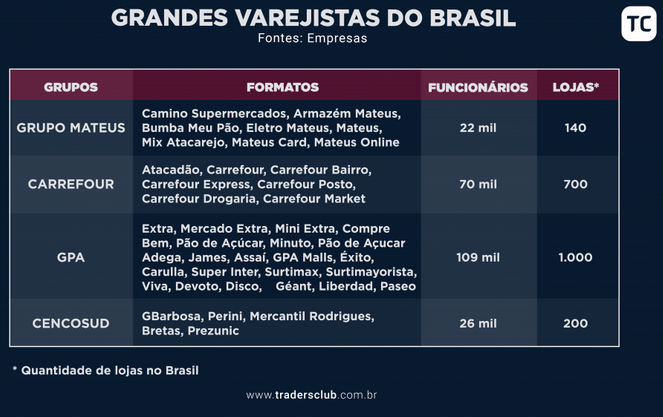

Ou

"O banco não descarta que players nacionais, como Pão de Açúcar, Carrefour e Grupo Big tentem aumentar sua presença nas regiões de origem do Grupo Mateus — 12% das lojas do GPA e 23% das lojas do Carrefour estão nas regiões Norte e Nordeste. No entanto, “a capilaridade de suas lojas, sua estrutura logística e sua escala criam um ambiente mais duro para novos [e antigos] entrantes”, dizem os analistas do banco."
fonte: https://exame.com/negocios/as-armas-do-grupo-mateus-para-bater-gpa-e-carrefour-no-nordeste/ de nov/2020

Na visão dos analistas do BTG, “embora o Grupo Mateus tenha superado os jogadores nacionais, a verdadeira competição nos próximos anos virá de pares regionais com muito menos escala. Ou seja, apesar de grandes players já conhecidos, há de se ficar atentos aos concorrentes regionais, que apesar de menores tem bastante capilaridade e conhecimento no nordeste



# 5. Obtendo latitude e longitude de cada loja

In [79]:
# Import
import geopandas as gpd


In [80]:
# Pegando as coordenadas - Teste
gpd.tools.geocode('BR-230, S/N, Sambaíba, Floriano, Piaui', provider='photon', user_agent="my-application")


,geometry,address
0,POINT (-43.00693 -6.76986),"Escola Municipal Raimundinha Carvalho, 64804-1..."


In [114]:
# Irei procurar por cidade, estado e cep - Perde precisão, mas por enquanto é o suficiente
# Se o resultado do google fosse mais padronizado daria para procurar por logradouro, bairro, etc e seria bem melhor
busca = lojas_full['Cidade'] + ', ' +  lojas['Estado'] + ', '  + lojas_full['Cep']
busca

0                 Juazeiro, Ba,  48909-347
1      Teixeira de freitas, Ba,  45995-002
2                 Floriano, PI,  64804-140
3             Parnaíba, PI,  Parnaíba - PI
4                 Piripiri, PI,  64260-000
                      ...                 
123        Vitorino Freire, Ma,  65716-000
124                Zé Doca, Ma,  65365-000
125              Itapipoca, Ce,  62504-142
126                 Sobral, Ce,  62042-120
127                Tianguá, Ce,  62320-000
Length: 128, dtype: object

In [161]:
# Agora pegando de todas as lojas do df
coordinates = gpd.tools.geocode(busca, provider='photon', user_agent="my-application")
coordinates


,geometry,address
0,POINT (-40.47217 -9.44937),"Residencial Juazeiro, 48907-218, Juazeiro, Bah..."
1,POINT (-39.67223 -17.52360),"Aeroporto de Teixeira de Freitas - 9 de Maio, ..."
2,POINT (-43.55631 -6.77387),"Rua Floriano, 64840-000, Guadalupe, Piauí, Brasil"
3,POINT (-41.76620 -2.91475),"Parnaíba, Piauí, Brasil"
4,POINT (-41.78635 -4.26944),"Centro Educacional Sesc Ler Piripiri, Rua Gerô..."
...,...,...
123,POINT (-45.24176 -4.28853),"Vitorino Freire, 65320-000, Maranhão, Brasil"
124,POINT (-45.65534 -3.27014),"Zé Doca, 65365-000, Maranhão, Brasil"
125,POINT (-39.51714 -3.55990),"Estrada para Itapipoca, 62514000, Itapipoca, C..."
126,POINT (-40.36287 -3.66009),"Cidade Pedro Mendes Carneiro, 62040000, Sobral..."


In [162]:
# Juntando no DataFrame com todas as lojas
lojas_full['Coordenadas'] = coordinates['geometry']
lojas_full.head(1)

,Tipo de Loja,Loja,Estado,Cidade,Endereço,Cep,Coordenadas
0,Mix Mateus,Juazeiro,Ba,Juazeiro,"Av. Epitacio Pessoa, S/N, Gleba C - Alto da Al...",48909-347,POINT (-40.47217 -9.44937)


In [163]:
# Nova coluna é tipo geometry
lojas_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Tipo de Loja  128 non-null    object  
 1   Loja          128 non-null    object  
 2   Estado        128 non-null    object  
 3   Cidade        128 non-null    object  
 4   Endereço      128 non-null    object  
 5   Cep           106 non-null    object  
 6   Coordenadas   128 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 7.1+ KB


In [164]:
# Transformando em 'object'
lojas_full['Coordenadas'] = lojas_full['Coordenadas'].astype('object')

In [165]:
# Separando Latitude de Longitude
# Deixando apenas os números
lojas_full['Coordenadas'] = lojas_full['Coordenadas'].apply(lambda x: str(x)[7:-1])

# Separando pelo espaço
lojas_full[['Lat', 'Lng']] = lojas_full['Coordenadas'].str.split(expand=True)

# Checando
lojas_full.head(5)

,Tipo de Loja,Loja,Estado,Cidade,Endereço,Cep,Coordenadas,Lat,Lng
0,Mix Mateus,Juazeiro,Ba,Juazeiro,"Av. Epitacio Pessoa, S/N, Gleba C - Alto da Al...",48909-347,-40.4721695 -9.4493704,-40.4721695,-9.4493704
1,Mix Mateus,Teixeira de freitas,Ba,Teixeira de freitas,"Av. Pres. Getúlio Vargas, 7979 - Sector Bahia ...",45995-002,-39.67223125277019 -17.52360045,-39.67223125277019,-17.52360045
2,Mix Mateus,Floriano,PI,Floriano,"BR-230, S/N - Sambaíba, Floriano - PI",64804-140,-43.5563096 -6.7738741,-43.5563096,-6.7738741
3,Mix Mateus,Parnaíba,PI,Parnaíba,"R. Projetada, 67 - Reis Veloso",Parnaíba - PI,-41.7661953 -2.9147515,-41.7661953,-2.9147515
4,Mateus Supermercados,Piripiri,PI,Piripiri,"Av. Dep. Raimundo Holanda, 1319 - Morro da Sau...",64260-000,-41.78634932881655 -4.26943805,-41.78634932881655,-4.26943805


In [169]:
# Ao transformar se perde uma casa de precisão, mas preciso que esteja em float
lojas_full['Lat'] = lojas_full['Lat'].astype(float)
lojas_full['Lng'] = lojas_full['Lng'].astype(float)
lojas_full.head(5)

,Tipo de Loja,Loja,Estado,Cidade,Endereço,Cep,Coordenadas,Lat,Lng
0,Mix Mateus,Juazeiro,Ba,Juazeiro,"Av. Epitacio Pessoa, S/N, Gleba C - Alto da Al...",48909-347,-40.4721695 -9.4493704,-40.472169,-9.449370
1,Mix Mateus,Teixeira de freitas,Ba,Teixeira de freitas,"Av. Pres. Getúlio Vargas, 7979 - Sector Bahia ...",45995-002,-39.67223125277019 -17.52360045,-39.672231,-17.523600
2,Mix Mateus,Floriano,PI,Floriano,"BR-230, S/N - Sambaíba, Floriano - PI",64804-140,-43.5563096 -6.7738741,-43.556310,-6.773874
3,Mix Mateus,Parnaíba,PI,Parnaíba,"R. Projetada, 67 - Reis Veloso",Parnaíba - PI,-41.7661953 -2.9147515,-41.766195,-2.914751
4,Mateus Supermercados,Piripiri,PI,Piripiri,"Av. Dep. Raimundo Holanda, 1319 - Morro da Sau...",64260-000,-41.78634932881655 -4.26943805,-41.786349,-4.269438


In [ ]:
# Checar o que aconteceu com a lojas sem endereço, dropar as linhas se necessário

# 6. Plotando Lojas no Mapa

In [170]:
import folium

In [171]:
# Definindo a base do mapa - Loja de Juazeiro na Bahia
mapa = folium.Map(location=[-9.447687335487565, -40.4921125539743],
                  tiles = 'Stamen terrain',
                  zoom_start=5)

In [172]:
# Adicionando o ícone
folium.Marker(location=[-9.447687335487565, -40.4921125539743], 
              popup='<i>Mix Mateus - Juazeiro</i>', 
              tooltip='Clique Aqui').add_to(mapa)

# Trocar cor do ícone 'icon=folium.Icon(color='red')' <- Dá pra personalizar e colocar imagem, colocar logo dos mercados

In [173]:
# Adiciona o círculo em volta do ícone
folium.CircleMarker(location=[-9.447687335487565, -40.4921125539743],
                   radius=50,
                   color='#3186cc',
                   fill=True,
                   fill_color='#3186cc',).add_to(mapa)

In [174]:
# Função para mostrar latitude e longitude ao se clicar no mapa
mapa.add_child(folium.LatLngPopup())

#### Upload de imagem do mapa, pois geralmente ele só mostra no meu computador, pois tenhos as libs necessárias

- Esse é o mapa gerado e é dinâmico, podendo dar zoom e manipular as direções

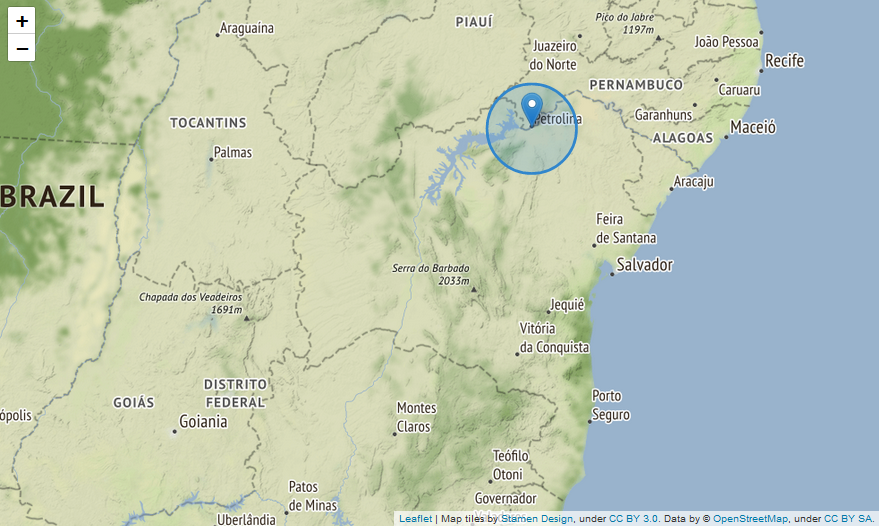

In [176]:
from folium import plugins

In [177]:
# Tratando as coordenadas para 2 listas
# Pegando direto do df de forma automática - Show, deu certo!
coordenadas = []
for lat, lng in zip(lojas_full.Lat.values, lojas_full.Lng.values):
    coordenadas.append([lng, lat])

coordenadas

[[-9.4493704, -40.4721695],
 [-17.52360045, -39.67223125277019],
 [-6.7738741, -43.5563096],
 [-2.9147515, -41.7661953],
 [-4.26943805, -41.78634932881655],
 [-5.209126, -42.7622974],
 [-5.2443457, -42.7334332],
 [-10.9422639, -37.08869612548335],
 [-9.36148845, -40.57031761357052],
 [-1.7179133, -48.8810787],
 [48.68806655, 6.181150361127399],
 [-1.3468752, -48.4069589],
 [-1.3603638, -48.4249927],
 [-1.374035, -48.4016623],
 [-1.374035, -48.4016623],
 [-1.5115928, -48.6204889],
 [-1.3799406163636363, -48.46039024545454],
 [48.68806655, 6.181150361127399],
 [-1.4150187251484347, -48.46654540484414],
 [9.0818199, -79.3933517],
 [-1.0891094, -46.714537],
 [48.68806655, 6.181150361127399],
 [-1.1862062, -47.1695827],
 [-1.2927031, -47.9223903],
 [48.68806655, 6.181150361127399],
 [-9.3348334, -50.3427734],
 [-4.2928111, -47.5559083],
 [-4.2928111, -47.5559083],
 [-2.9340845, -48.9452751],
 [-5.2639874, -50.4646374],
 [-4.4352852, -49.1260605],
 [-5.3471534, -49.13150038625456],
 [-5.3636

#### No mapa abaixo é possível ver a perda de precisão e principalmente alguns pontos que não estão certos

- 2 opções aqui para continuar a análise:
    - Dropar esses com problema
    - Ou achar um jeito de corrigir de vez, pegando todos os endereços certinho (que seria o ideal e eu pretendo)


In [178]:
mapa = folium.Map(location=[-9.447687335487565, -40.4921125539743],
                  tiles = 'Stamen terrain',
                  zoom_start=5)

# Mapa de Calor
mapa.add_child(plugins.HeatMap(coordenadas))

#### Novamente colocando uma imagem salva aqui:

1ª Perspectiva:

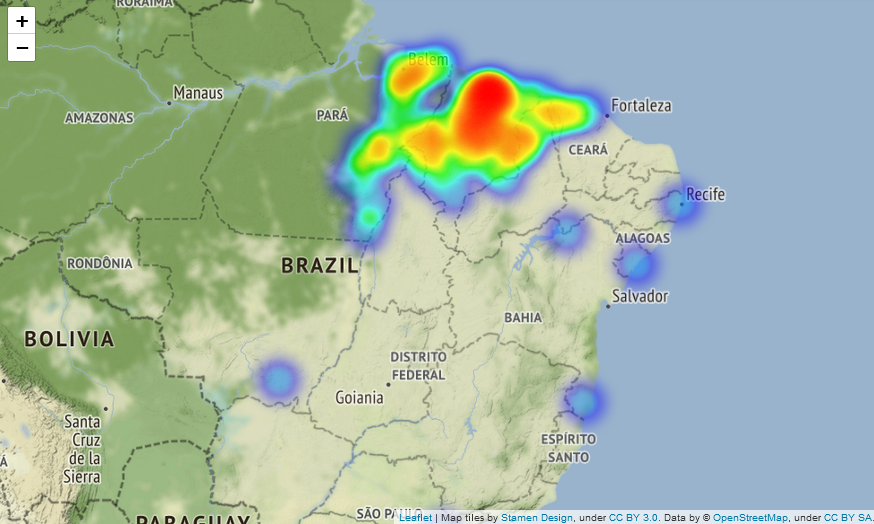



2ª Perspectiva: 

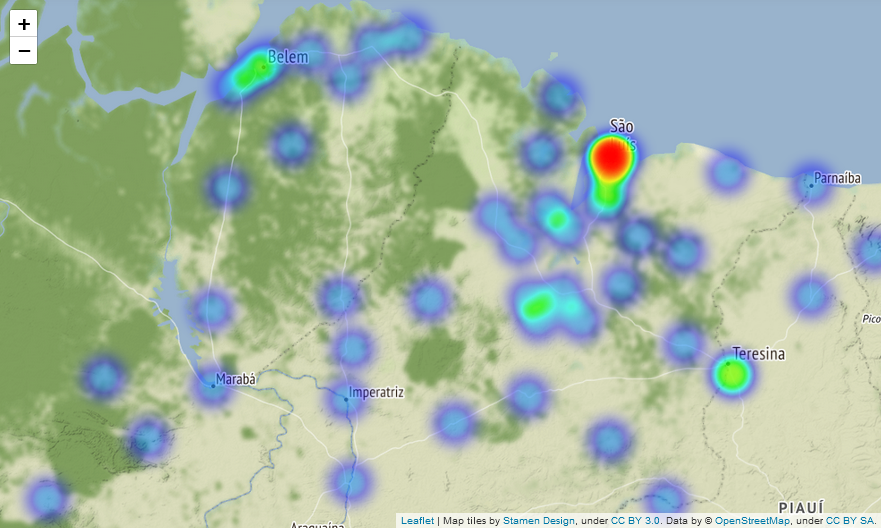

In [ ]:
# Salvando mapa para poder manipular no html
mapa.save('mapa.html')

# Faltam muitas coisas ainda

- Resolver 

- Colocar READ.me